# Does diversity beat ability - the stairway model

Reijula & Kuorikoski (2020)

In [108]:
# IMPORTS

import sys
import numpy as np
import pandas as pd
import sys 
import itertools
import random

import logging
logging.basicConfig()

#MATPLOTLIB & SEABORN
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime

In [109]:
def spinning_cursor():
    while True:
        for cursor in '|/-\\':
            yield cursor

sc = spinning_cursor()

def update_spinner():
    sys.stdout.write('\b')
    sys.stdout.write(next(sc))
    sys.stdout.flush()

update_spinner()

|

In [161]:
def create_noise_ls( size , distribution , minP , maxP ):
    """
    returns a task landscape used by Hong & Page 2004 and by Grim et al. 2019.
    possible to experiment with payoffs drawn from an exponential distribution (distribution == 'exp')
    """
    
    logger = logging.getLogger( 'noise_task' )
    logger.setLevel( logging.WARNING ) 
    
    if distribution == 'uniform':
        ls = np.random.randint( low=minP , high=maxP , size=size ) # higher end, we want max value to be included
        logger.debug( ls )
      
    elif distribution == 'exp':
        ls = np.random.exponential( scale=100 , size = size )  
    
    return ls


def create_stairway_ls( size , noiseDist , stepSet , minP , maxP ):
    """
    returns a stairway landscape with step set = sequence
    """
    
    ls = create_noise_ls( size , noiseDist , minP , maxP ) # start with the random task 
    
    # fill in an increasing subsequence according to 'sequence'
    c = 0
    index = 0 # note, stairway sequence begins from location=0
    jump = 0
    score = 100
    increase = 100
    while True:
        index += random.choice(stepSet) 
        score += increase      
        if index >= size: break      
        ls[ index ] = score
    return ls


def normalize_landscape( ls ):
    return ls / np.amax ( ls )


def normalize_scapes( lsList ):
    normalized = []
    for ls in lsList:
        normalized.append( normalize_landscape( ls ) )
    return normalized


def generateLandscapes( lType , normalized , number , size , distribution , expertHeur , minP , maxP ):
    landscapeList = []
    for n in range( number ):
        if lType == 'noise':
            landscapeList.append( create_noise_ls( size , distribution , minP , maxP ) )
        elif lType == 'stairway':
            landscapeList.append( create_stairway_ls( size , distribution , expertHeur , minP , maxP ) )
        else: print( 'Error: landscape type not recognized' )
    
    if normalized:
        return normalize_scapes( landscapeList )
    else: 
        return landscapeList


def lsAveragePayoff( ls ):
    return np.mean( ls )


# TESTS 
l1 = create_noise_ls( 10 , 'uniform' , 1 , 100 )
lsAveragePayoff( l1 )
print( f'Original: {l1}' )
norm = normalize_landscape( l1 )
print( f'Normalized: {norm}' )
print()

l2 = create_stairway_ls( 10 , 'uniform' , [1,2] , 1, 100 )
print( f'Original: {l2}' )
norm = normalize_landscape( l2 )
print( f'Normalized: {norm}' )
print()

testScapes = generateLandscapes( 'noise' , False , 2 , 10 , 'uniform' , [5] , 1 , 100 )
print( testScapes )
print()
print( normalize_scapes( testScapes ) )

Original: [81 91 38 42  6 61 79 75  3  1]
Normalized: [0.89010989 1.         0.41758242 0.46153846 0.06593407 0.67032967
 0.86813187 0.82417582 0.03296703 0.01098901]

Original: [ 95 200 300  31 400 500  59 600 700  73]
Normalized: [0.13571429 0.28571429 0.42857143 0.04428571 0.57142857 0.71428571
 0.08428571 0.85714286 1.         0.10428571]

[array([56, 18, 80, 96, 87, 43, 67,  2, 74, 59]), array([15,  3, 14, 29, 92, 20, 76, 43,  8, 43])]

[array([0.58333333, 0.1875    , 0.83333333, 1.        , 0.90625   ,
       0.44791667, 0.69791667, 0.02083333, 0.77083333, 0.61458333]), array([0.16304348, 0.0326087 , 0.15217391, 0.31521739, 1.        ,
       0.2173913 , 0.82608696, 0.4673913 , 0.08695652, 0.4673913 ])]


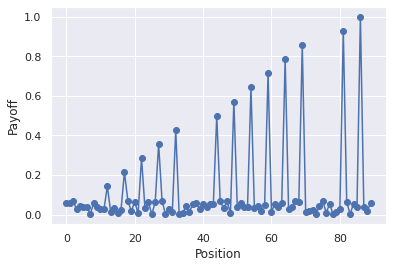

In [10]:
## PLOT AN EXAMPLE OF A STAIRWAY LANDSCAPE 

el = normalize_landscape( create_stairway_ls( 90 , 'uniform' , [5,12] , 1 , 100 ) )

plt.figure()
plt.plot( el , marker='o' )
plt.xlabel( r'Position' )
plt.ylabel( 'Payoff' )

plt.savefig( 'stairway_ls.png' )
plt.show()

In [69]:
class Agent():
    
    def __init__( self , heuristicSize , maxJump ):
        """
        returns a new agent with random heuristic
        """  
        logger = logging.getLogger( 'create_agent' )
        logger.setLevel( logging.WARNING) 
        
        self.heuristicSize = heuristicSize 
        self.currentPerformance = 0 # performance on the current landscape 
        self.overallPerformanceList = [] # list of performances on different landscapes
        self.overallPerformance = 0
        self.heuristics = np.random.choice( a=list( range( 1 , maxJump+1 ) ) , size=heuristicSize , replace=False )
        # note here: no overlap allow between an agent's heuristics
        
        logger.debug( f'heuristicsize {self.heuristicSize}, heuristics are: {self.heuristics}' )
        
        
    def setHeuristic( self , heur ):
        self.heuristicSize = len( heur )
        self.heuristics = heur
    
    
    def getHeuristics( self ):
        return self.heuristics
    
    
    def updateOverallPerformance( self ):
        self.overallPerformance.append( self.currentPerformance )
        self.currentPerformance = 0
    
    
    def playRound( self , ls , startPosition ):
        """
        play a round on landcape=ls, starting from startPosition
        """
        logger = logging.getLogger( 'play_round' )
        logger.setLevel( logging.WARNING ) 
        
        lsSize = len( ls )

        initialPayoff = ls[ startPosition ] 
        logger.debug( f'Initial position: {startPosition}, initial score: {initialPayoff}' )
        
        currentPosition = startPosition
        currentPayoff = ls[ currentPosition ]
        heuristicIndex = 0
        changes = False 
        roundNumber = 0
        updated = 0
        stop = False 
        
        while not stop:
            logger.debug( '-' )
            logger.debug( f'current position: {currentPosition}, current payoff: {currentPayoff}' )
                    
            candidatePosition = ( currentPosition + self.heuristics[ heuristicIndex ] ) % lsSize # % = modulus operator
            candidatePayoff = ls[ candidatePosition ]
            
            logger.debug( f'candidate position: {candidatePosition}, candidate payoff: {candidatePayoff}' )
            
            if candidatePayoff > currentPayoff: # must be a _strictly_ larger payoff for switching ...
                logger.debug( 'Switching' ) 
                
                currentPosition = candidatePosition
                currentPayoff = candidatePayoff 
                updated = roundNumber # updated = 'round when last score improved'
                
            heuristicIndex += 1
            
            if heuristicIndex == self.heuristicSize:
                heuristicIndex = 0
            
            if (roundNumber - updated) == self.heuristicSize:
                stop = True 
                logger.debug( 'Stopping' )
            
            roundNumber += 1
        
        return currentPosition , currentPayoff
    
    
    def playLandscape( self , ls , allPositions ):
        """
        This allows doing a variation of the original:
        - (a) original: allPositions = True. Play by starting from all positions 
        - (b) allPositions=False: just start from location 0
        """
        
        logger = logging.getLogger( 'play_round' )
        logger.setLevel( logging.WARNING ) 
        
        if allPositions: 
            positions = np.zeros( len( ls ) )
            scores = np.zeros( len( ls ) )
            
            for i in range( len( scores ) ):
                positions[i] , scores[i] = self.playRound( ls=ls , startPosition=i )
                logger.debug( scores[i] )
            return np.mean( positions ) , np.mean( scores )
        else:
            position , score = self.playRound( ls=ls , startPosition=0 )
            return position , score
            

# TESTS

a = Agent( 3 , 12 ) 

noise_scape = create_noise_ls( 10 , distribution='uniform' , minP=1, maxP=100 )
print( f'Noise landscape average payoff: {lsAveragePayoff ( noise_scape )}' )

position, payoff = a.playRound( noise_scape , 0 )
print(f'One round played on noise landscape, ended in position {position}, payoff {payoff}')

position, payoff = a.playLandscape( noise_scape , allPositions=True )
print(f'One round played on noise landscape, starting from all positions, mean position and payoff: {position}, {payoff}')

print()

stairway_scape = create_stairway_ls( 30 , 'uniform' , [3,5] , 1 , 100 ) 
print(f'Stairway landscape: {stairway_scape}' )
print( f'Stairway landscape average payoff: {lsAveragePayoff ( stairway_scape )}, max payoff: {np.max(stairway_scape)}' )
position, payoff = a.playRound( stairway_scape , 0 )
print(f'One round played on stairway landscape, ended in position {position}, payoff {payoff}')


Noise landscape average payoff: 40.1
One round played on noise landscape, ended in position 7, payoff 89
One round played on noise landscape, starting from all positions, mean position and payoff: 8.2, 81.2

Stairway landscape: [ 73  24  57 200  90  36 300  92   7 400  15  97 500  95  22 600  62  55
 700  65  24  69   9 800  16  32  52  70 900  43]
Stairway landscape average payoff: 183.5, max payoff: 900
One round played on stairway landscape, ended in position 7, payoff 92


In [70]:
def mergeLists( lists ):
    return list( itertools.chain( *lists ) )

In [90]:
class Group():
    
    def __init__( self , agents ):
        """
        create a group of agents from the 'agents' list given as parameter
        """
        self.agents = agents
        self.groupSize = len( self.agents )
    
    
    def getHeuristics( self ):
        h = []
        for a in self.agents:
            h.append( a.heuristics )
        return h
    
    
    def overlap( self ):
        """
        how many overlapping heuristics in the group?
        """
        h = []
        for a in self.agents:
            h.append( list( a.heuristics ) )
        merged = mergeLists( h )
        
        return len( merged ) - len( set( merged ) ) # casting as set removes duplicates
        
        
    def playRound( self , ls , startPosition , shuffle ):
        logger = logging.getLogger( 'group_play_round' )
        logger.setLevel( logging.WARNING )
        
        if shuffle: random.shuffle( self.agents ) # random.shuffle() shuffles the list IN PLACE
        
        stop = False 
        agentIndex = 0
        currentPosition = startPosition 
        currentPayoff = ls[ currentPosition ]
        roundNumber = 0
        updated = 0
        
        while not stop:
            logger.debug( f'current position: {currentPosition}, current payoff: {currentPayoff}' )
                          
            agent = self.agents[ agentIndex ]
                
            agentPosition , agentPayoff = agent.playRound( ls , currentPosition ) # agent plays starting from the current position 
            logger.debug( f'agent {agentIndex} reached position {agentPosition} with payoff {agentPayoff}' )
                          
            if agentPayoff > currentPayoff:
                currentPosition = agentPosition
                currentPayoff = agentPayoff
                updated = roundNumber 
                logger.debug( 'Switching' )
            
            agentIndex += 1
            
            if agentIndex == self.groupSize:
                agentIndex = 0
            
            if (roundNumber - updated) == self.groupSize:
                stop = True 
                logger.debug( 'Stopping' )
    
            roundNumber += 1
            
        return currentPosition , currentPayoff 
    
            
    def playLandscape( self , ls , allPositions , shuffleOnOff ):
        """
        group-play through a landscape 
        either by (a) starting from all positions, or (b) starting from 0
        return performance average OR (endposition, endpayoff)
        """
        logger = logging.getLogger( 'group_play_round' )
        logger.setLevel( logging.WARNING )

        if allPositions: 
            positions = np.zeros( len( ls ) )
            scores = np.zeros( len( ls ) )

            for i in range( len( scores ) ):
                positions[i], scores[i] = self.playRound( ls=ls , startPosition=i , shuffle=shuffleOnOff )
                logger.debug( scores[i] )
            return np.mean( positions ) , np.mean( scores )
        else:
            return self.playRound( ls=ls , startPosition=0 , shuffle=shuffleOnOff )

        
# TESTING
noise_scape = create_noise_ls( 10 , distribution='uniform' , minP=1 , maxP=100 )
stairway_scape = create_noise_ls( 10 , distribution='uniform' , minP=1 , maxP=100 )

lss = [noise_scape, stairway_scape]
print( f'noise landscape: {noise_scape}' )

a = Agent( 2 , 6 ) 
b = Agent( 2 , 6 )  
c = Agent( 2 , 6 )  

g = Group( [a,b,c] )

print( f'heuristics in the group: {g.getHeuristics()}' )
print( f'overlap: {g.overlap()}' )
print()

for ls in lss:
    pos, payoff = g.playLandscape( ls , allPositions=False , shuffleOnOff=True )
    print( f'allPositions=False,shuffle=True, position & payoff {pos}, {payoff}' ) 
    pos, payoff = g.playLandscape( ls , allPositions=True , shuffleOnOff=True )
    print( f'allPositions=True,shuffle=True, position & payoff {pos}, {payoff}' )
    pos, payoff = g.playLandscape( ls , allPositions=False , shuffleOnOff=False )
    print( f'allPositions=False,shuffle=False, position & payoff {pos}, {payoff}' )
    print()

noise landscape: [56 56 81 27 32  1  5  2 25 85]
heuristics in the group: [array([6, 5]), array([4, 3]), array([2, 3])]
overlap: 1

allPositions=False,shuffle=True, position & payoff 2, 81
allPositions=True,shuffle=True, position & payoff 4.6, 77.6
allPositions=False,shuffle=False, position & payoff 2, 81

allPositions=False,shuffle=True, position & payoff 6, 83
allPositions=True,shuffle=True, position & payoff 6.0, 83.0
allPositions=False,shuffle=False, position & payoff 6, 83



In [104]:
# calculate the proportion of size-10 random groups, k=3, l=12, having full heuristic 

k = 3
l = 12
heuristicSet = list( range( 1 , l+1 ) ) # all heuristics from 1 to maxJump 
groupSize = 10   
sampleSize = 5000

perms = list( itertools.permutations( heuristicSet , r=k ) ) # all the different heuristics k=3,l=12

pop = []
for s in range( sampleSize ):
    ml = mergeLists( random.sample( perms , groupSize ) ) # form "group heuristics" my random sampling & pooling
    heuristic_len = len( set( ml ) ) # group heuristic size after removing duplicates
    pop.append( heuristic_len )

isTwelve = [i for i in pop if i==12]
isEleven = [i for i in pop if i==11]

print( f'proportion of full heuristics: {len(isTwelve) / len(pop)}' )
print( f'proportion of 12 or 11 size heuristics: {(len(isTwelve)+len(isEleven)) / len(pop)}' )

proportion of full heuristics: 0.4896
proportion of 12 or 11 size heuristics: 0.8746


In [192]:
class Population():
   
    def __init__( self , maxJump , heuristicSize ): #maxJump = parameter l in the model
        """
        create a full/exhaustive set of agents 
        """
        self.agents = []
        self.maxJump = maxJump 
        self.heuristicSize = heuristicSize
        
        heuristicSet = list( range( 1 , self.maxJump+1 ) ) # all heuristics from 1 to maxJump 
        
        perms = list( itertools.permutations( heuristicSet , r=self.heuristicSize ) ) # get permutations by using itertools
        for p in perms:
            a = Agent( self.heuristicSize, self.maxJump ) # take a blank agent ...
            a.setHeuristic( p )
            self.agents.append( a ) # add to population
            
        random.shuffle( self.agents ) #shuffle the order of agents
   

    def rankAgents( self , allPositions , landscapes ):
        logger = logging.getLogger( 'tournament' )
        logger.setLevel( logging.WARNING )
        #sys.stdout.write( 'Running single-agent tournament:  ' )

        for a in self.agents:
            a.overallPerformanceList = [] # clear the performance list for all agents
        
        for l in range( len( landscapes ) ):
            update_spinner() #sys.stdout.write( '*' )

            lands = landscapes[l] # all agents play with the same ls      
            logger.debug( f'for {l} landscape, average payoff: { lsAveragePayoff( lands ) }' )
            for a in self.agents:
                _ , score = a.playLandscape( lands , allPositions=allPositions ) # for now, throw away position information
                a.overallPerformanceList.append( score )
                
        for a in self.agents:
            a.overallPerformance = np.mean( np.array( a.overallPerformanceList ) )
            logger.debug( a.overallPerformanceList )
            logger.debug( a.overallPerformance )
            logger.debug( a.heuristics )
            logger.debug( ' ' )
        
        #sort according to performnace
        logger.debug('\n\nnot sorted: ' + str([a.overallPerformance for a in self.agents]))
        
        self.agentsSorted = sorted( self.agents , key=lambda x: x.overallPerformance , reverse=True ) # sort agents list by perf
        
        logger.debug('\n\nsorted: '+str([a.overallPerformance for a in self.agentsSorted]))
            
            
    def buildSupergroup( self , size ):
        """
        build a supergroup of size 'size'
        """
        return Group( self.agentsSorted[:size] )

    
    def buildRandomgroup( self , size ): #it's already random, self.agents shuffled at creation stage 
        return Group( self.agents[:size] )
    
    
# TESTS   
ls = generateLandscapes( lType = 'noise' ,
                         normalized = False , 
                         number = 1 , 
                         size = 2000 , 
                         distribution = 'uniform' ,
                         expertHeur = [2] , 
                         minP = 1  , 
                         maxP = 100 )

pop = Population( maxJump=3 , heuristicSize=2 )
ls = noise_scape = create_noise_ls( 100 , distribution='uniform' , minP=1 , maxP=100 )

for a in pop.agents:
    print(a.heuristics)

pop.rankAgents( allPositions=True , landscapes=[ls] )
    
print('Unsorted list of agents in the population:')
for a in pop.agents:
    #print(a)
    print(a.heuristics)
    print(a.overallPerformance)
    print()

print()  

print('Sorted list of agents in the population:')
for a in pop.agentsSorted:
    print(a.heuristics)
    print(a.overallPerformance)
    print()
  
    
sg = pop.buildSupergroup( 3 )
rg = pop.buildRandomgroup( 3 )
print('All agents'+str([a.overallPerformance for a in pop.agents]))
print('Supergroup'+str([a.overallPerformance for a in sg.agents]))
print('Random group'+str([a.overallPerformance for a in rg.agents]))

(1, 2)
(2, 3)
(3, 2)
(2, 1)
(3, 1)
(1, 3)
|Unsorted list of agents in the population:
(1, 2)
78.81

(2, 3)
80.76

(3, 2)
80.15

(2, 1)
78.57

(3, 1)
77.53

(1, 3)
78.2


Sorted list of agents in the population:
(2, 3)
80.76

(3, 2)
80.15

(1, 2)
78.81

(2, 1)
78.57

(1, 3)
78.2

(3, 1)
77.53

All agents[78.81, 80.76, 80.15, 78.57, 77.53, 78.2]
Supergroup[80.76, 80.15, 78.81]
Random group[78.81, 80.76, 80.15]


# The experiments

In [133]:
# (1) REPLICATING RESULTS FROM THE INDIVIDUAL-AGENT RINGWORLD TOURNAMENT (see Hong & Page 2004, p. 16387)

ls = generateLandscapes( lType = 'noise' ,
                         normalized = False , 
                         number = 1 , # note, Hong & Page p.16387 reports results from a single run
                         size = 2000 , 
                         distribution = 'uniform' ,
                         expertHeur = [3] , # ignored for noise landscapes
                         minP = 1  , 
                         maxP = 100 )

pop = Population( maxJump=13 , heuristicSize=3 )

pop.rankAgents( allPositions=True , landscapes=ls )
print()
print(f'Best agent score: {pop.agentsSorted[0].overallPerformance}')
print(f'Worst agent score: {pop.agentsSorted[-1].overallPerformance}')

Running single-agent tournament: |
Best agent score: 85.1795
Worst agent score: 82.66


In [176]:
# (2) REPLICATING THE ORIGINAL RINGWORLD MODEL (Hong & Page 2004; see also Grim et al. 2019)

## set up the experiment

def runExperiment( p , pop , landscapes ):
    
    # generate groups
    ranGroup = pop.buildRandomgroup( p['groupSize'] ) 
    
    superGroup = pop.buildSupergroup( p['groupSize'] )

    # run experiment
    ranGroupScores = np.zeros( p['landscapePopSize'] )
    superGroupScores = np.zeros( p['landscapePopSize'] )

    ranGroupPositions = np.zeros( p['landscapePopSize'] )
    superGroupPositions = np.zeros( p['landscapePopSize'] )

    #sys.stdout.write( 'Running group tournament: ' )

    for i in range( p['landscapePopSize'] ):
        lands = landscapes[ i ]
        ranGroupPositions[ i ] , ranGroupScores[ i ] = ranGroup.playLandscape( lands , 
                                                                               allPositions=p['allPositions'] , 
                                                                               shuffleOnOff=p['shuffleGroup'] )
        superGroupPositions[ i ] , superGroupScores[ i ] = superGroup.playLandscape( lands , 
                                                                                     allPositions=p['allPositions'] , 
                                                                                     shuffleOnOff=p['shuffleGroup'] )
        update_spinner() 

    df = pd.DataFrame( {'ranGroupEndPosition' : ranGroupPositions , 
                        'ranGroupScore' : ranGroupScores , 
                        'superGroupEndPosition' : superGroupPositions , 
                        'superGroupScore' : superGroupScores } )
    
    return df, ranGroup.overlap() , superGroup.overlap()

In [152]:
# Sweep Groupsize from 1 to 15

## parameters

paramsRingworld = {
    'heuristicSize'    : 3 ,
    'maxJump'          : 12 ,
    'landscapeSize'    : 2000 , 
    'landscapeType'    : 'noise' ,
    'normalize'        : False ,
    'expertHeuristic'  : [11,12] , #makes no difference when landscapeType == noise
    'minPayoff'        : 1 ,
    'maxPayoff'        : 100 ,
    'landscapePopSize' : 1 , 
    'groupSize'        : 10 , # not used in this exp
    'allPositions'     : True , # determines how game is played. do you always determine performance by starting from all positions (a la Grim et al)
    'typeOfDist'       : 'uniform' , # experiment with different payoff distributions: 'uniform', 'exp' ...
    'shuffleGroup'     : False # whether to always shuffle the order in which agents address the task
    }

## (a) Generate landscapes
p = paramsRingworld
ls = generateLandscapes( lType = p['landscapeType'] ,
                         normalized = p['normalize'] , 
                         number = p['landscapePopSize'] , 
                         size = p['landscapeSize'] , 
                         distribution = p['typeOfDist'] ,
                         expertHeur = p['expertHeuristic'] , 
                         minP = p['minPayoff'] , 
                         maxP = p['maxPayoff'] 
                        )

## (b) Generate population and run tournament to find the expert group(s) 
pop = Population( p['maxJump'] , p['heuristicSize'] )
pop.rankAgents( allPositions=p['allPositions'] , landscapes=ls ) # this takes a while for larger populations


## (c) Run exp
maxGroupSize = 15 

ranScores = pd.Series( maxGroupSize )
ranPositions = pd.Series( maxGroupSize )

superScores = pd.Series( maxGroupSize )
superPositions = pd.Series( maxGroupSize )
groupSize = pd.Series( maxGroupSize )
ranOverlap = pd.Series( maxGroupSize )
superOverlap = pd.Series( maxGroupSize )

### sweep through group size range
for gs in range( maxGroupSize ):
    paramsRingworld['groupSize'] = gs +1
    print( f'Group size: {gs+1}' )
    
    df, rO , sO = runExperiment( paramsRingworld , pop , ls )
    
    ranScores[gs] = df['ranGroupScore'].mean()
    superScores[gs] = df['superGroupScore'].mean()
    ranPositions[gs] = df['ranGroupEndPosition'].mean()
    superPositions[gs] = df['superGroupEndPosition'].mean()
    
    groupSize[gs] = gs+1
    ranOverlap[gs] = rO
    superOverlap[gs] = sO
    
    
## (d) collect results
groupsDf = pd.DataFrame( { 'Group size'           : groupSize ,
                           'Random Group Score'   : ranScores ,
                           'Random Group End Position' : ranPositions ,
                           'Random Group Overlap' : ranOverlap , 
                           'Super Group Score'    : superScores ,
                           'Super Group End Position' : superPositions ,
                           'Super Group Overlap'  : superOverlap 
                          } )
    

Running single-agent tournament: -Group size: 1
Running group tournament:\Group size: 2
Running group tournament:|Group size: 3
Running group tournament:/Group size: 4
Running group tournament:-Group size: 5
Running group tournament:\Group size: 6
Running group tournament:|Group size: 7
Running group tournament:/Group size: 8
Running group tournament:-Group size: 9
Running group tournament:\Group size: 10
Running group tournament:|Group size: 11
Running group tournament:/Group size: 12
Running group tournament:-Group size: 13
Running group tournament:\Group size: 14
Running group tournament:|Group size: 15
Running group tournament:/

In [150]:
groupsDf

,Group size,Random Group Score,Random Group End Position,Random Group Overlap,Super Group Score,Super Group End Position,Super Group Overlap
0,1,84.0000,1001.0000,0,86.0000,992.0000,0
1,2,89.6190,995.5300,1,88.3445,993.3260,2
2,3,91.8955,997.6430,2,89.9975,994.8340,4
3,4,93.2090,998.6095,3,89.9975,994.8340,7
4,5,93.9190,997.7085,5,93.0085,995.8855,7
5,6,94.3080,998.0190,7,93.0050,995.9205,10
6,7,94.2920,998.0160,10,93.4395,996.5405,12
7,8,94.2920,998.0160,13,93.4500,996.5335,15
8,9,94.2920,998.0160,16,93.4500,996.5335,18
9,10,94.2920,998.0160,19,93.4500,996.5335,21


In [159]:
# Results for group size 10 (again, compare Hong & Page 2004, p. 16387)
sizeTen = groupsDf[groupsDf["Group size"] == 10]
sizeTen

print(f'Random group score @ group size 10: {sizeTen["Random Group Score"]}')
print(f'Super group score @ group size 10: {sizeTen["Super Group Score"]}')

Random group score @ group size 10: 9    93.2535
Name: Random Group Score, dtype: float64
Super group score @ group size 10: 9    90.7115
Name: Super Group Score, dtype: float64


random_and_super_performances_d_2021_01_26_h_14.png


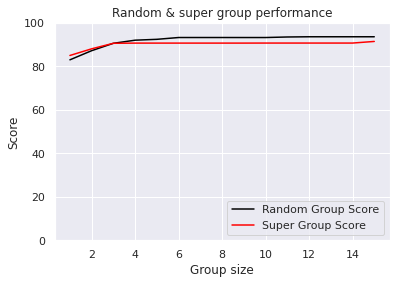

In [160]:
# Visualize

plt.figure()
plt.plot(groupsDf['Group size'] , groupsDf['Random Group Score'], color='black' , label='Random Group Score' )
plt.plot(groupsDf['Group size'] , groupsDf['Super Group Score'], color='red' , label='Super Group Score' )
plt.ylim(0,100)


plt.legend(loc='lower right')
plt.xlabel(r'Group size')
plt.ylabel('Score')
plt.title('Random & super group performance')

from datetime import datetime

now = datetime.now() # current date and time
dateStr = now.strftime("d_%Y_%m_%d_h_%H")

fileName = 'random_and_super_performances_' + dateStr + '.png' 
print(fileName)
plt.savefig(fileName)
plt.show()

In [215]:
# (3) STAIRWAY LANDSCAPES 

paramsStairway = {
    'heuristicSize'    : 3 ,
    'maxJump'          : 12 ,
    'landscapeSize'    : 2000 ,
    'landscapeType'    : 'stairway' , 
    'normalize'        : True ,
    'stepSet'          : [10,11,12] , # for results in the paper, we used a fixed step set, but uncomment row " expertheuristic ... below for similar results with a random set"
    'minPayoff'        : 1 ,
    'maxPayoff'        : 100 ,
    'landscapePopSize' : 50 , # (100 for results in the paper) 
    'groupSize'        : 15 ,
    'allPositions'     : False , # determines how game is played. do you always determine performance by starting from all positions (a la Grim et al)
    'typeOfDist'       : 'uniform' , # experiment with different payoff distributions: 'uniform', 'exp' ...
    'shuffleGroup'     : True , # whether to always shuffle the order in which agents address the task
    'reps'             : 10 #how many reps for the whole thing (100 for results in the paper)
    }

p = paramsStairway

#set up the final dataframe
bigDf = pd.DataFrame( columns=[ 'Rep',
                                'Group Size', 
                                'Random Group Score' , 
                                'Random Group Overlap',  
                                'Super Group Score' ,
                                'Super Group Overlap' ] )

for rep in range( p['reps'] ):
    # (1) Generate landscapes
    p['stepSet'] = np.random.choice( np.array( (range(7) ))+5+1 , size=3 , replace=False) # uncomment for random step set
    # notice that here elements of the step set are chosen from [6,12] so that the task is difficult enough
    ls = generateLandscapes( lType = p['landscapeType'] ,
                             normalized = p['normalize'] , 
                             number = p['landscapePopSize'] , 
                             size = p['landscapeSize'] , 
                             distribution = p['typeOfDist'] ,
                             expertHeur = p['stepSet'] , 
                             minP = p['minPayoff'] , 
                             maxP = p['maxPayoff'] )

    # (2) Generate population and run tournament to construct expert group 
    pop = Population( p['maxJump'] , p['heuristicSize'] )
    pop.rankAgents( allPositions=p['allPositions'] , landscapes=ls )


    ## (3) Run exp
    maxGroupSize = 15

    ranScores = pd.Series( maxGroupSize )
    superScores = pd.Series( maxGroupSize )
    groupSize = pd.Series( maxGroupSize )
    ranOverlap = pd.Series( maxGroupSize )
    superOverlap = pd.Series( maxGroupSize )

    # sweep through group size range
    for gs in range( maxGroupSize ):
        p['groupSize'] = gs +1
        #print( f'Group size: {gs+1}' )

        df, rO , sO = runExperiment( p , pop , ls )

        ranScores[gs] = df['ranGroupScore'].mean()
        superScores[gs] = df['superGroupScore'].mean()
        groupSize[gs] = gs+1
        ranOverlap[gs] = rO*1.0
        superOverlap[gs] = sO*1.0


    # collect results
    groupsDf = pd.DataFrame( { 'Rep'                  : rep ,
                               'Group Size'           : groupSize ,
                               'Random Group Score'   : ranScores ,
                               'Random Group Overlap' : ranOverlap , 
                               'Super Group Score'    : superScores ,
                               'Super Group Overlap'  : superOverlap })
    
    bigDf = bigDf.append( groupsDf )

|

In [220]:
# save results

now = datetime.now() # current date and time
dateStr = now.strftime("d_%Y_%m_%d_h_%H")

fileName = 'stairway_experiment_' + dateStr + '.csv' 
print(fileName)
bigDf.to_csv( path_or_buf=fileName , sep=',' , header=True , index=False )

stairway_experiment_d_2021_01_26_h_20.csv


In [217]:
bigDf.groupby( by='Group Size' , as_index=False ).mean()

,Group Size,Random Group Score,Random Group Overlap,Super Group Score,Super Group Overlap
0,1,0.000000,0.0,0.000000,0.0
1,2,0.012286,0.8,0.846576,3.0
2,3,0.016404,1.8,0.852561,6.0
3,4,0.086799,3.5,0.824669,9.0
4,5,0.381478,5.4,0.796790,12.0
5,6,0.469529,8.0,0.768887,15.0
6,7,0.769988,10.6,0.858572,17.0
7,8,0.874272,13.1,0.868533,19.4
8,9,0.884151,15.6,0.902411,21.8
9,10,0.888193,18.5,0.908376,24.3


stairway_results_d_2021_01_26_h_20.png


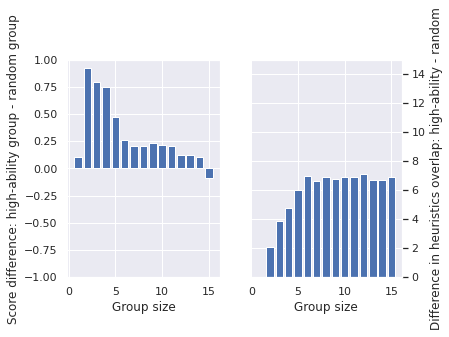

In [221]:
# visualize

stairway_results = pd.read_csv(fileName , sep=',' )

# groupby
stairway_grouped = stairway_results.groupby( by='Group Size' , as_index=False ).mean()

stairway_grouped['scoreDif'] = stairway_grouped['Super Group Score'] - stairway_grouped['Random Group Score'] 
stairway_grouped['overlapDif'] = stairway_grouped['Super Group Overlap'] - stairway_grouped['Random Group Overlap'] 


# plot

fig, (ax1, ax2) = plt.subplots(1, 2) #1 row, 2 cols
ax1.bar(exp2_grouped['Group Size'] , exp2_grouped['scoreDif'] , label='score: random-super' )
ax2.bar(exp2_grouped['Group Size'] , exp2_grouped['overlapDif'] , label='overlap: random-super' )
ax1.set(xlabel='Group size', ylabel='Score difference: high-ability group - random group',ylim=(-1,1))
ax2.yaxis.set_label_position("right")
ax2.set(xlabel='Group size', ylabel='Difference in heuristics overlap: high-ability - random',ylim=[0,15])
ax2.yaxis.tick_right()

# save image
now = datetime.now() 
dateStr = now.strftime("d_%Y_%m_%d_h_%H")
plotName = 'stairway_results_' + dateStr + '.png'
print(plotName)
fig.savefig(plotName)

In [239]:
# (4) STAIRWAY LANDSCAPES EXPLORATION. SWEEP STEPSET SIZE 1-6; GROUPSIZE 1-15 --> VISUALIZE AS HEATMAP

paramsStairway2 = {
    'heuristicSize'    : 3 ,
    'maxJump'          : 12 ,
    'landscapeSize'    : 2000 ,
    'landscapeType'    : 'stairway' , 
    'normalize'        : True ,
    'stepSet'          : [11,7,5,12,9,8] , #again, the original was ran with a fixed step set; uncomment below for random set
    'minPayoff'        : 1 ,
    'maxPayoff'        : 100 ,
    'landscapePopSize' : 10 , 
    'groupSize'        : 10 ,
    'allPositions'     : False , # determines how game is played. do you always determine performance by starting from all positions (a la Grim et al)
    'typeOfDist'       : 'uniform' , # experiment with different payoff distributions: 'uniform', 'exp' ...
    'shuffleGroup'     : True , # whether to always shuffle the order in which agents address the task
    'reps'             : 10 #how many reps for the whole thing 
    }


maxGroupSize = 15 
p = paramsStairway2

#initialize the big dataframe
bigDf2 = pd.DataFrame( columns=[ 'Rep' , 
                                 'Step set size' , 
                                 'Group size',  
                                 'Random group score' ,
                                 'Super group score' ] )

for rep in range( p['reps'] ):
    p['stepSet'] = np.random.choice( np.array( (range(7) ))+5+1 , size=6 , replace=False) # uncomment for random step set
    for e in range( len( p['stepSet'] ) ):
        ss = p['stepSet'][:(e+1)] # take e first elements from p['stepSet']

        # (1) Generate landscapes
        ls = generateLandscapes( lType = p['landscapeType'] ,
                                 normalized = p['normalize'] ,
                                 number = p['landscapePopSize'] , 
                                 size = p['landscapeSize'] , 
                                 distribution = p['typeOfDist'] ,
                                 expertHeur = ss , 
                                 minP = p['minPayoff'] , 
                                 maxP = p['maxPayoff'] )

        # (2) Generate population and run tournament to construct expert group 
        pop = Population( p['maxJump'] , p['heuristicSize'] )
        pop.rankAgents( allPositions=p['allPositions'] , landscapes=ls )

        ## (3) Run exp
        maxGroupSize = 15

        ranScores = pd.Series( maxGroupSize )
        superScores = pd.Series( maxGroupSize )
        groupSize = pd.Series( maxGroupSize )
        ranOverlap = pd.Series( maxGroupSize )
        superOverlap = pd.Series( maxGroupSize )
        ssSize = pd.Series( maxGroupSize )

        # sweep through group size range
        for gs in range( maxGroupSize ):
            p['groupSize'] = gs +1
            #print( f'Group size: {gs+1}' )

            df, rO , sO = runExperiment( p , pop , ls )

            ranScores[gs] = df['ranGroupScore'].mean()
            superScores[gs] = df['superGroupScore'].mean()
            groupSize[gs] = gs+1
            ranOverlap[gs] = rO*1.0
            superOverlap[gs] = sO*1.0
            ssSize[gs] = e+1


        # collect results
        results = pd.DataFrame( { 'Rep'                    : rep ,
                                  'Step set size'          : ssSize ,
                                  'Group size'             : groupSize ,
                                  'Random group score'     : ranScores ,
                                  'Super group score'      : superScores })
        bigDf2 = bigDf2.append( results )

        
# save results        
now = datetime.now() # current date and time
dateStr = now.strftime("d_%Y_%m_%d_h_%H")

fileName = 'stairway_experiment_2_' + dateStr + '.csv' 
print()
print(fileName)
bigDf2.to_csv( path_or_buf=fileName , sep=',' , header=True , index=False )

/
stairway_experiment_2_d_2021_01_26_h_21.csv



stairway_diffPlot_d_2021_01_26_h_21.png


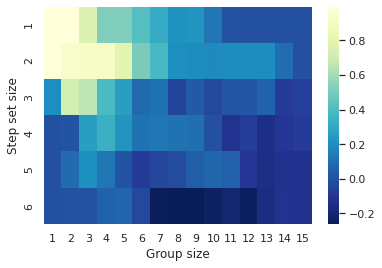

In [240]:
# plot the heatmap 

stairway_exp_2_results = pd.read_csv(fileName , sep=',' )
#stairway_exp_2_results = pd.read_csv('stairway_experiment_2_d_2021_01_26_h_21.csv' , sep=',' )

stairway_exp_2_results['scoreDif'] = stairway_exp_2_results['Super group score'] - stairway_exp_2_results['Random group score'] 

stairway_exp_2_results_grouped = stairway_exp_2_results.groupby( by=['Step set size', 'Group size'] , as_index=False ).mean() 
pivoted = stairway_exp_2_results_grouped.pivot(index='Step set size', columns='Group size', values='scoreDif')


# plot&save results        
now = datetime.now() 
dateStr = now.strftime("d_%Y_%m_%d_h_%H")

plotName = 'stairway_diffPlot_' + dateStr + '.png' 
print()
print(plotName)

f, axs = plt.subplots()
sns.heatmap(pivoted , cmap="YlGnBu_r" , robust=True, ax=axs).get_figure() 
axs.set(xlabel='Group size', ylabel='Step set size')
f.savefig(fileName)